# 164992_Fitting+MCMC

Using HD164992 dataset, we demonstrate how to

- perform a max-likelihood fit (with multiple telescopes)
- do an MCMC exploration of the posterior space (with multiple telescopes)


In [1]:
# Preliminary imports
#%pylab osx
%pylab inline
import radvel
import radvel.likelihood
import radvel.plotting
import copy
import pandas as pd
import os
from scipy import optimize
import corner
from astropy.time import Time
import numpy as np
from numpy import *
import copy

Populating the interactive namespace from numpy and matplotlib


In [2]:
def bin_same_night(rv):
    rv['date'] = pd.Series(Time(rv.t,format='jd', scale='utc').iso).str.slice(stop=10)
    rv_mean = rv.groupby('date',as_index=False).mean()
    rv_n = rv.groupby('date',as_index=False).size()
    print len(rv_n),len(rv_mean)
    rv_mean['errvel'] = rv_mean['errvel'] / np.array(np.sqrt(rv_n))
    return rv_mean

path = os.path.join(radvel.DATADIR,'164922.hdf')
rv_hires_rk = pd.read_hdf(path,'hires_rk')
rv_hires_rj = pd.read_hdf(path,'hires_rj')
rv_apf = pd.read_hdf(path,'apf')

rv_hires_rj = bin_same_night(rv_hires_rj)
rv_hires_rk = bin_same_night(rv_hires_rk)
rv_apf = bin_same_night(rv_apf)

t_start = rv_hires_rk.iloc[0]['t']
t_stop = rv_apf.iloc[-1]['t']
ti = linspace(t_start,t_stop,10000)

122 122
51 51
68 68


In [7]:
#Some conveinence functions
def initialize_model():
    time_base = 2456778
    params = radvel.RVParameters(2,basis='per tc secosw sesinw logk')
    params['per1'] = 1201.1 + 0.4
    params['tc1'] = 2456778 + 1
    params['secosw1'] = 0.01 
    params['sesinw1'] = 0.01
    params['logk1'] = 1
    params['per2'] = 75.765 + 0.1
    params['tc2'] = 2456277.6
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['logk2'] = 1
    params['dvdt'] = 0
    params['curv'] = 0
    mod = radvel.RVModel(params, time_base=time_base)
    return mod

def plot_results(like,color,label):
    fig = gcf()
    axL = fig.get_axes()
    jit = like.params[like.jit_param]
    yerr = np.sqrt(like.yerr**2 + jit**2)
    bjd0 = 2450000

    sca(axL[0])
    errorbar(
        like.x-bjd0, like.model(like.x)+like.residuals(), 
        yerr=yerr, fmt='o',color=color,label=label
        )
    plot(ti-bjd0, like.model(ti))
    fig.set_tight_layout(True)
    sca(axL[1])
    errorbar(
        like.x-bjd0, like.residuals(), 
        yerr=yerr, fmt='o'
        )


# Max-likelihood fitting

1. Initialize model
2. Build up likelihoods
3. Instantiate posterior
4. Perform fit

In [4]:
def initialize_likelihood(rv,suffix):
    like = radvel.likelihood.RVLikelihood( 
        mod, rv.t, rv.vel, rv.errvel,suffix=suffix)
    return like
mod = initialize_model()

# Build up HIRES >2004 likelihood
like_hires_rj = initialize_likelihood(rv_hires_rj,'_hires_rj')
like_hires_rj.params['gamma_hires_rj'] = 1.0
like_hires_rj.params['jit_hires_rj'] = np.log(1)

# Build up HIRES <2004 likelihood
like_hires_rk = initialize_likelihood(rv_hires_rk,'_hires_rk')
like_hires_rk.params['gamma_hires_rk'] = 1.0
like_hires_rk.params['jit_hires_rk'] = np.log(1)

# Build up APF
like_apf = initialize_likelihood(rv_apf,'_apf')
like_apf.params['gamma_apf'] = 1.0
like_apf.params['jit_apf'] = np.log(1)

# Build composite likelihood
like = radvel.likelihood.CompositeLikelihood(
    [like_hires_rj,like_hires_rk,like_apf])

# Set initial values for jitter
like.params['jit_hires_rk'] = log(2.6)
like.params['jit_hires_rj'] = log(2.6)
like.params['jit_apf'] = log(2.6)

# Do not vary dvdt or jitter (Fulton 2015)
like.vary['dvdt'] = False
like.vary['curv'] = False
like.vary['jit_hires_rk'] = False
like.vary['jit_hires_rj'] = False
like.vary['jit_apf'] = False

In [5]:
# Instantiate posterior
post = radvel.posterior.Posterior(like)
post0 = copy.deepcopy(post)

# Add in priors
post.priors += [radvel.prior.EccentricityPrior( 2 )] # Keeps eccentricity < 1

# Perform Max-likelihood fitting
res  = optimize.minimize(
    post.neglogprob_array,
    post.get_vary_params(), 
    method='Powell',
    options=dict(maxiter=100000,maxfev=100000,xtol=1e-8)
    )


print "Initial loglikelihood = %f" % post0.logprob()
print "Final loglikelihood = %f" % post.logprob()
print post

Initial loglikelihood = -1423.353953
Final loglikelihood = -770.026526
parameter                     value      vary
curv                              0      False
dvdt                              0      False
gamma_apf                  0.971764       True
gamma_hires_rj             0.220682       True
gamma_hires_rk             0.242198       True
jit_apf                    0.955511      False
jit_hires_rj               0.955511      False
jit_hires_rk               0.955511      False
logk1                       1.97149       True
logk2                      0.778232       True
per1                        1198.61       True
per2                        75.7666       True
secosw1                   -0.228012       True
secosw2                  -0.0663733       True
sesinw1                    0.258976       True
sesinw2                    0.430915       True
tc1                     2.45677e+06       True
tc2                     2.45628e+06       True
Priors
------
Eccentricity constraine

## Make a nice plot

/Users/bfulton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


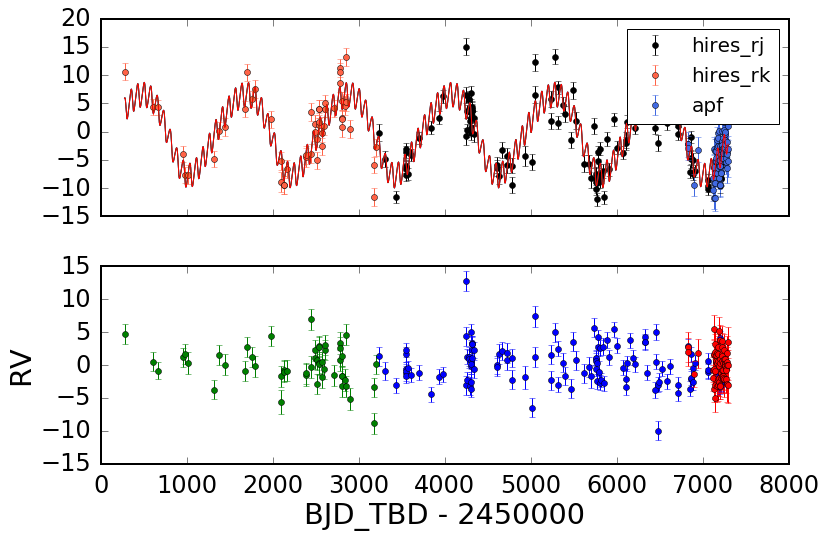

In [8]:
plt.close('all')
fig,axL = subplots(nrows=2,figsize=(12,8),sharex=True)
plot_results(like.like_list[0],'black','hires_rj') # plot best fit model
plot_results(like.like_list[1],'Tomato','hires_rk') # plot best fit model
plot_results(like.like_list[2],'RoyalBlue','apf') # plot best fit model
axL[0].legend()
bjd0 = 2450000
xlabel('BJD_TBD - %i' % bjd0)
ylabel('RV')
[ax.grid() for ax in axL]
draw()

# Perform MCMC posterior exploration

In [9]:
# Only use one thread!
df = radvel.mcmc(post,threads=1,nwalkers=40,nrun=1000)



MCMC: WARNING: chains did not pass convergence tests. They are likely not well-mixed.


In [10]:
df_cps = post.params.basis.to_cps(df)
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
df_cps[labels].quantile([0.14,0.5,0.84]).T

,0.14,0.5,0.84
per1,1196.913980,1198.762870,1201.076601
tc1,2456769.144899,2456774.930398,2456779.189430
e1,0.101070,0.122098,0.140976
k1,7.008510,7.187457,7.350206
per2,75.736370,75.774923,75.807141
tc2,2456277.101978,2456278.524374,2456279.707219
e2,0.119013,0.192542,0.253440
k2,2.021464,2.166351,2.306072
gamma_hires_rj,0.071574,0.210105,0.326899
gamma_hires_rk,-0.006993,0.240080,0.463257


Compare with parameters from fulton et al. (2016)
---------

/Users/bfulton/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/bfulton/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:600: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


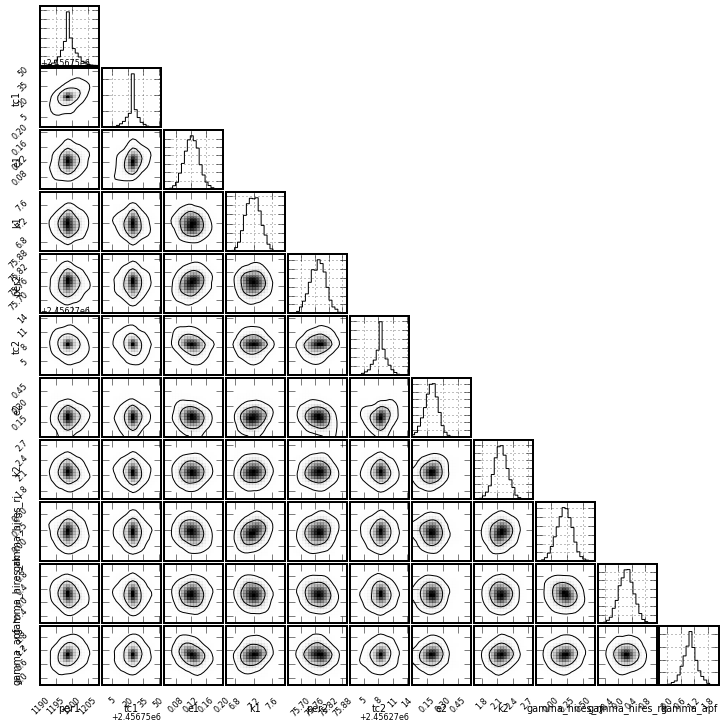

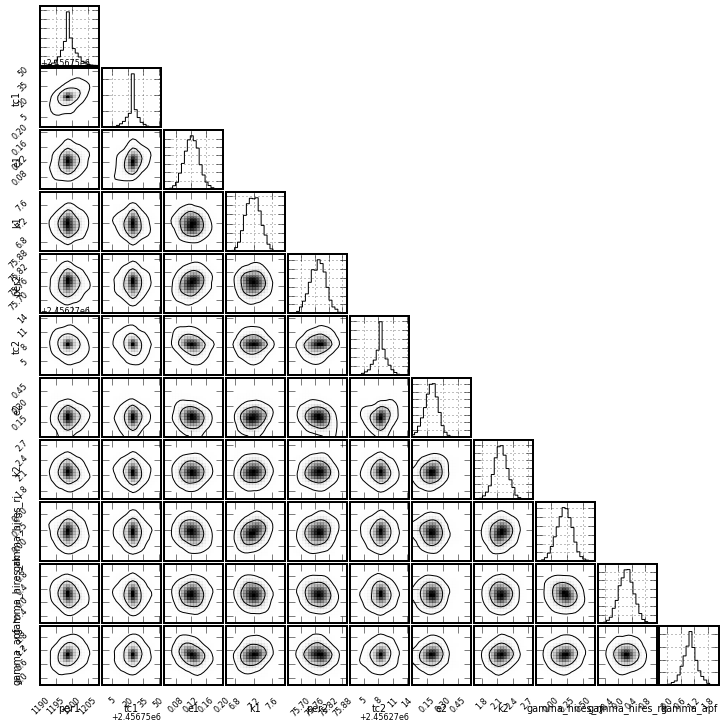

In [11]:
,close all
labels = 'per1 tc1 e1 k1 per2 tc2 e2 k2 gamma_hires_rj gamma_hires_rk gamma_apf '.split()
rc('font',size=8)
dims = len(labels)
fig,axL = subplots(nrows=dims,ncols=dims,figsize=(10,10))
corner_kw = dict(
    labels=labels,
    levels=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20,
    )
corner.corner(df_cps[labels],fig=fig,**corner_kw)

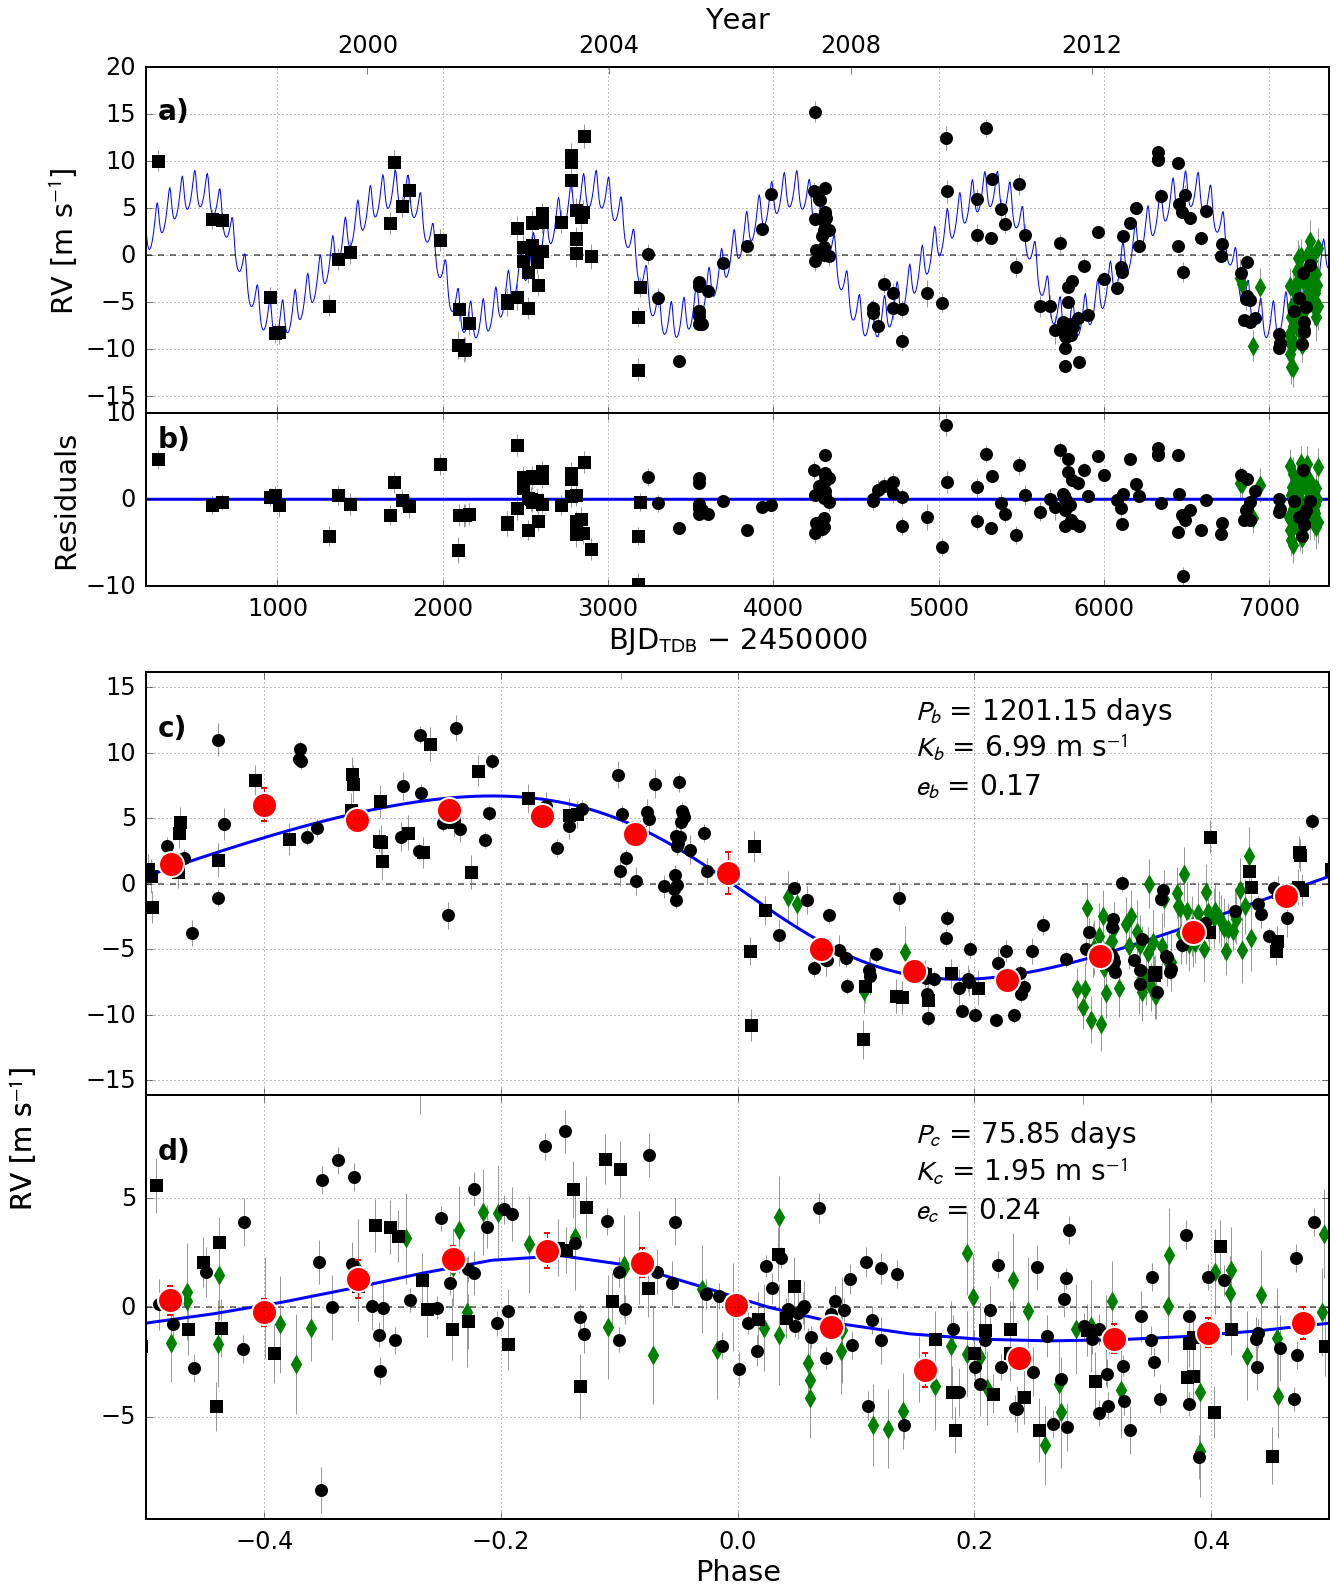

In [12]:
reload(radvel.plotting)
radvel.plotting.rv_multipanel_plot(post)